# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

## EP4: Aplicação de classificadores na base "Adult"

## Autor: Rodrigo Gebara Reis

# 1. Configuração:

## 1.1. Importação das bibliotecas:

Vamos fazer a importação das bibliotecas pertinentes: pandas, matplotlib e seaborn para análise dos dados e criação de gráficos, numpy para algumas operações matemáticas, sklearn e tensorflow para os classificadores em si:

In [1]:
#Geral
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import random

#ML
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing as prep
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble
import sklearn.tree
from sklearn import neural_network, svm
from xgboost import XGBClassifier
import tensorflow as tf
import keras
from keras import Sequential, regularizers
from keras.layers import Dense
from tensorflow.python.framework import ops
from keras.callbacks import EarlyStopping
from tqdm import tqdm as tqdm


#Seeds para reprodutibilidade dos resultados
random.seed(36)
np.random.seed(36)
tf.random.set_seed(36)

# 2. Data prep:

## 2.1. Importação dos dados de treino e de teste:

Leitura dos dados de treino da tabela CSV, considerando as entradas "?" como "Nan", devolvendo a forma do DataFrame de treino:

In [2]:
adult = pd.read_csv("../input/adult-pmr3508/train_data.csv", names=[
        "Id","Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?",skiprows=[0])
adult.shape

(32560, 16)

Leitura dos dados de teste da tabela CSV, considerando as entradas "?" como "Nan", devolvendo a forma do DataFrame de teste:

In [3]:
testAdult = pd.read_csv("../input/adult-pmr3508/test_data.csv", names=[
        "Id","Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?",skiprows=[0])
testAdult.shape

(16280, 15)

## 2.2. Informações sobre o dataset:

Primeiro visualizamos as primeiras cinco linhas do arquivo de treino:

In [4]:
adult.head()

,Id,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [5]:
adult = adult.drop("Id", axis = 1)
testAdult = testAdult.drop("Id", axis = 1)

In [6]:
adult.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


Com isso, percebemos 15 variáveis: 14 independentes e uma de classe ("Target"), que queremos prever.

## 2.3. Tratamento de dados faltantes:

O comando abaixo fornece o número de dados faltantes em cada coluna:

In [7]:
adult.isnull().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education-Num        0
Martial Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Country            583
Target               0
dtype: int64

Observando o número de linhas com dados faltantes em relação ao número total, temos:

In [8]:
missing_data_columns = adult.columns[adult.isnull().any()]
print("Há", adult[adult.isnull().any(axis=1)][missing_data_columns].shape[0], "dados faltantes, que representam {:.2f}%".format(100*adult[adult.isnull().any(axis=1)][missing_data_columns].shape[0]/adult.shape[0]), "do total.")

Há 2399 dados faltantes, que representam 7.37% do total.


Com isso, percebemos que os dados faltantes encontram-se nas colunas $\textit{Workclass}$, $\textit{Occupation}$ e $\textit{Country}$.

Agora devemos analisar como eles estão distribuídos:

Workclass:  count       30724
unique          8
top       Private
freq        22696
Name: Workclass, dtype: object 

Elementos Faltantes: 1836 = 5.64% do total


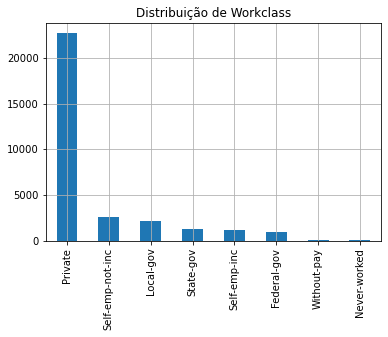

In [9]:
print("Workclass: ", adult["Workclass"].describe(include='all'), "\n")

plt.figure()
adult["Workclass"].value_counts().plot(kind="bar")
plt.title("Distribuição de Workclass")
plt.grid("minor")

print("Elementos Faltantes: {}".format(adult["Workclass"].isnull().sum()), 
      "= {:.2f}% do total".format(100*adult["Workclass"].isnull().sum()/adult["Workclass"].size))

Occupation:  count              30717
unique                14
top       Prof-specialty
freq                4140
Name: Occupation, dtype: object 

Elementos Faltantes: 1843 = 5.66% do total


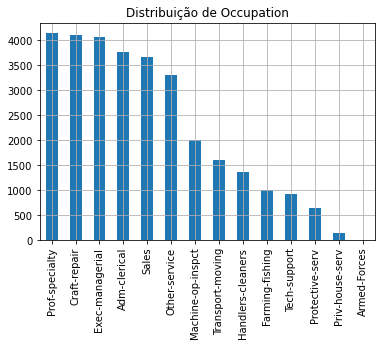

In [10]:
print("Occupation: ", adult["Occupation"].describe(include='all'), "\n")

plt.figure()
adult["Occupation"].value_counts().plot(kind="bar")
plt.title("Distribuição de Occupation")
plt.grid("minor")

print("Elementos Faltantes: {}".format(adult["Occupation"].isnull().sum()), 
      "= {:.2f}% do total".format(100*adult["Occupation"].isnull().sum()/adult["Occupation"].size))

Country:  count             31977
unique               41
top       United-States
freq              29169
Name: Country, dtype: object 

Elementos Faltantes: 583 = 1.79% do total


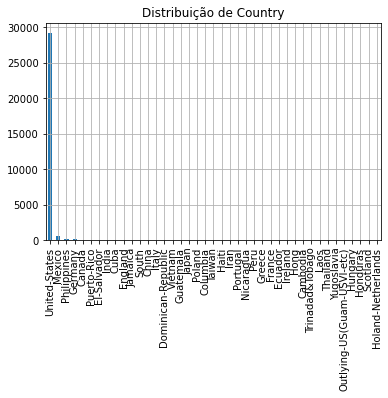

In [11]:
print("Country: ", adult["Country"].describe(include='all'), "\n")

plt.figure()
adult["Country"].value_counts().plot(kind="bar")
plt.title("Distribuição de Country")
plt.grid("minor")

print("Elementos Faltantes: {}".format(adult["Country"].isnull().sum()), 
      "= {:.2f}% do total".format(100*adult["Country"].isnull().sum()/adult["Country"].size))

Para "Country" e "Workclass", podemos utilizar a moda para completar os dados faltantes, já que ela é muito mais frequente que os demais valores. Para "Occupation", vamos simplesmente remover as linhas:

In [12]:
moda = adult['Workclass'].describe().top
adult['Workclass'] = adult['Workclass'].fillna(moda)

moda = adult['Country'].describe().top
adult['Country'] = adult['Country'].fillna(moda)

adult = adult.dropna()

Observando novamente a descrição dos dados, vemos que não há mais dados faltantes:

In [13]:
adult.isnull().sum()

Age               0
Workclass         0
fnlwgt            0
Education         0
Education-Num     0
Martial Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
Target            0
dtype: int64

Agora vamos realizar o mesmo procedimento para os dados de teste:

In [14]:
testAdult.isnull().sum()

Age                 0
Workclass         963
fnlwgt              0
Education           0
Education-Num       0
Martial Status      0
Occupation        966
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours per week      0
Country           274
dtype: int64

Novamente, como a moda tem frequência relativamente alta nos atributos, vamos utilizá-la para completar os dados faltantes:

In [15]:
moda = testAdult['Workclass'].describe().top
testAdult['Workclass'] = testAdult['Workclass'].fillna(moda)

moda = testAdult['Country'].describe().top
testAdult['Country'] = testAdult['Country'].fillna(moda)

moda = testAdult['Occupation'].describe().top
testAdult['Occupation'] = testAdult['Occupation'].fillna(moda)

## 2.4. Análise dos dados em relação à renda:

Primeiro, vamos criar uma cópia do dataframe. É interessante fazer isso pois vamos utilizar o "LabelEncoder" do SKLearn para melhor visualizar os dados:

In [16]:
analysis = adult.copy()

Agora, vamos transformar nossa variável de classe em uma variável binária com zeros e uns, apenas.

In [17]:
le = LabelEncoder()
analysis["Target"] = le.fit_transform(analysis["Target"])

In [18]:
analysis["Target"]

0        0
1        0
2        0
3        0
4        1
        ..
32555    1
32556    0
32557    0
32558    0
32559    0
Name: Target, Length: 30717, dtype: int64

### 2.4.1. Análise dos dados numéricos:

Separando os dados numéricos:

In [19]:
numerical_entries = ["Age","fnlwgt","Education-Num","Capital Gain","Capital Loss","Hours per week"]

Agora vamos procurar entender o comportamento geral dos dados e como eles interagem entre si. O primeiro gráfico que vamos gerar será um Heatmap, que representa a correlação entre as variáveis, acompanhado por um pairplot entre todas as variáveis numéricas:

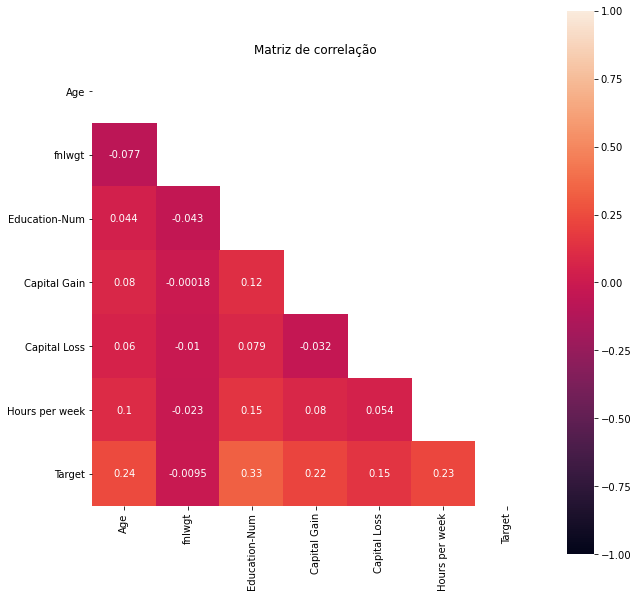

In [20]:
mask = np.triu(np.ones_like(analysis.corr(), dtype=np.bool))
plt.figure(figsize=(10,10))
plt.title("Matriz de correlação")
sns.heatmap(analysis.corr(), mask=mask, square = True, annot=True, vmin=-1, vmax=1)
plt.show()

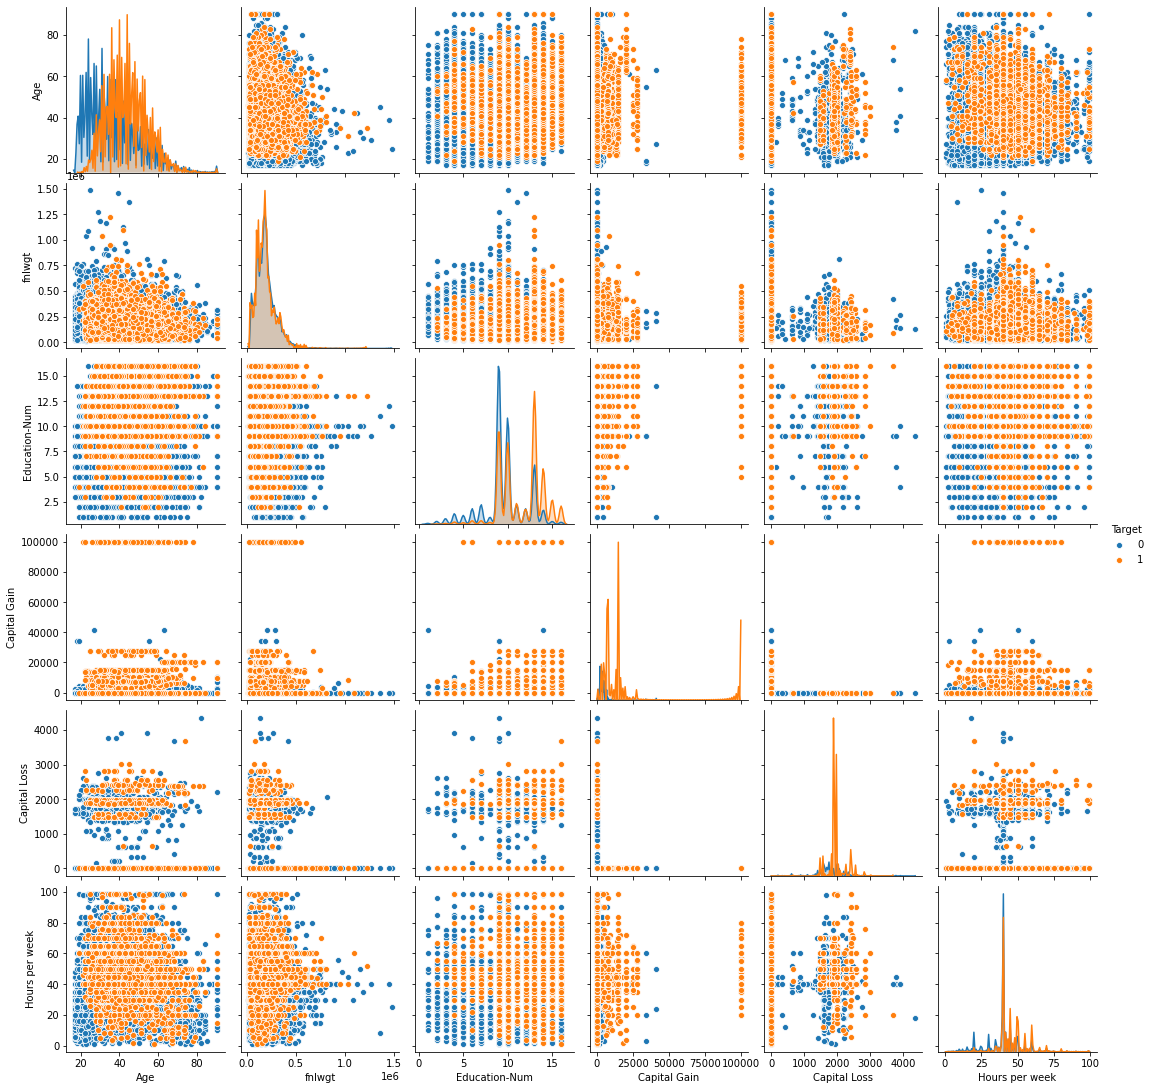

In [21]:
sns.pairplot(analysis, vars = numerical_entries, hue = "Target", diag_kws={'bw': 0.2})

A partir dos pairplots e do heatmap, percebe-se que a variável "fnlwgt" não possui correlação alguma com nenhum outro atributo. Assim, ela será removida de nossa análise.

### 2.4.2. Análise das variáveis categóricas:

Inicialmente, vamos criar gráficos para analisar a distribuição das variáveis:

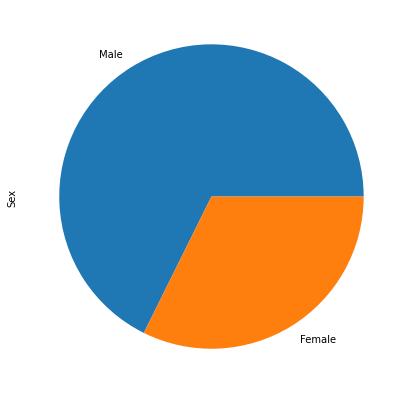

In [22]:
categorical_entries = ["Sex", "Relationship", "Education", "Occupation", "Workclass", "Race"]

plt.figure(figsize=(13, 7))
analysis["Sex"].value_counts().plot(kind = 'pie')

Vemos que há mais homens do que mulheres nesse dataset. Quantitativamente:

In [23]:
male = analysis[analysis["Sex"] == "Male"].count()[0]

female = analysis.shape[0] - male

In [24]:
print("Temos {0} homens e {1} mulheres, ou seja, apenas {2:3.2f}% são mulheres.".format(male, female, female*100/(female+male)))

Temos 20787 homens e 9930 mulheres, ou seja, apenas 32.33% são mulheres.


Fazendo o mesmo para etnias distintas:

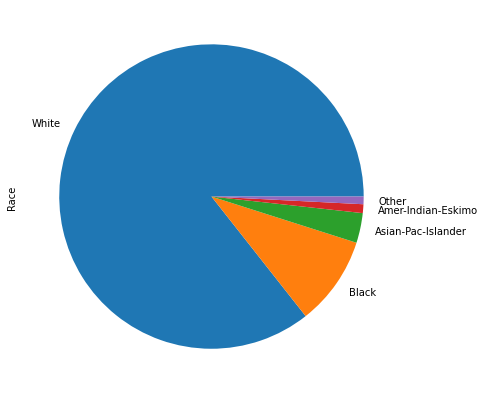

In [25]:
plt.figure(figsize=(13, 7))
analysis["Race"].value_counts().plot(kind = 'pie')

Claramente, a maioria é branca.

In [26]:
white = analysis[analysis["Race"] == "White"].count()[0]
print("Temos {:.2f}% brancos.".format(white*100/(analysis.shape[0])))

Temos 85.62% brancos.


Podemos fazer análises similares para o restante das variáveis categóricas (exceto "Country", que será discutida mais à frente):

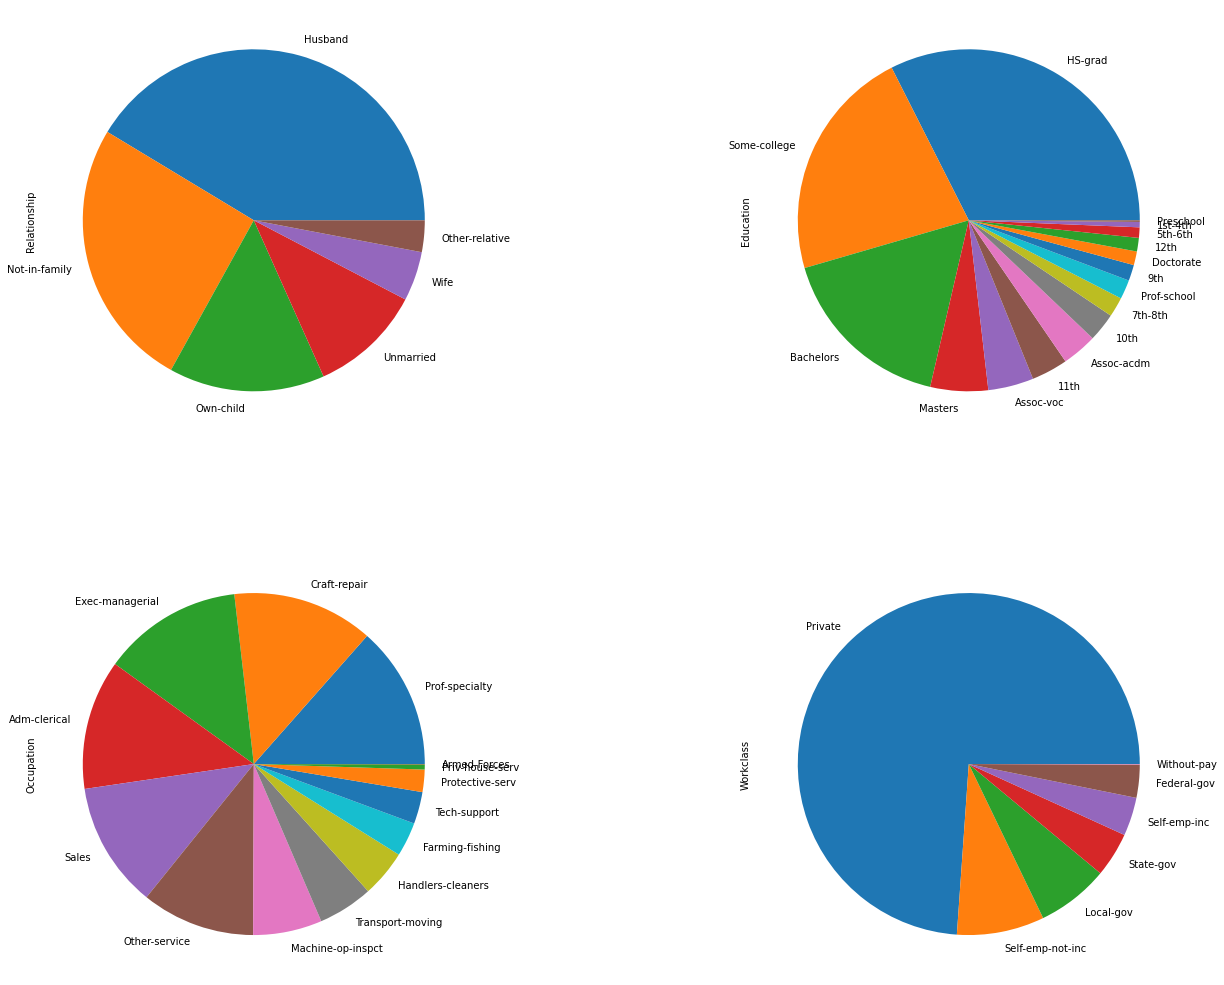

In [27]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout(pad = .4, w_pad = .5, h_pad = 1.)

m, n = 0, 0
for i in ["Relationship", "Education", "Occupation", "Workclass"]:
    analysis[i].value_counts().plot(kind = 'pie', ax = axes[m, n], figsize = (20, 15))
    n += 1
    if n > 1:
        n = 0
        m += 1

Agora, vamos criar gráficos que relacionam essas variáveis à renda, a variável de classe:

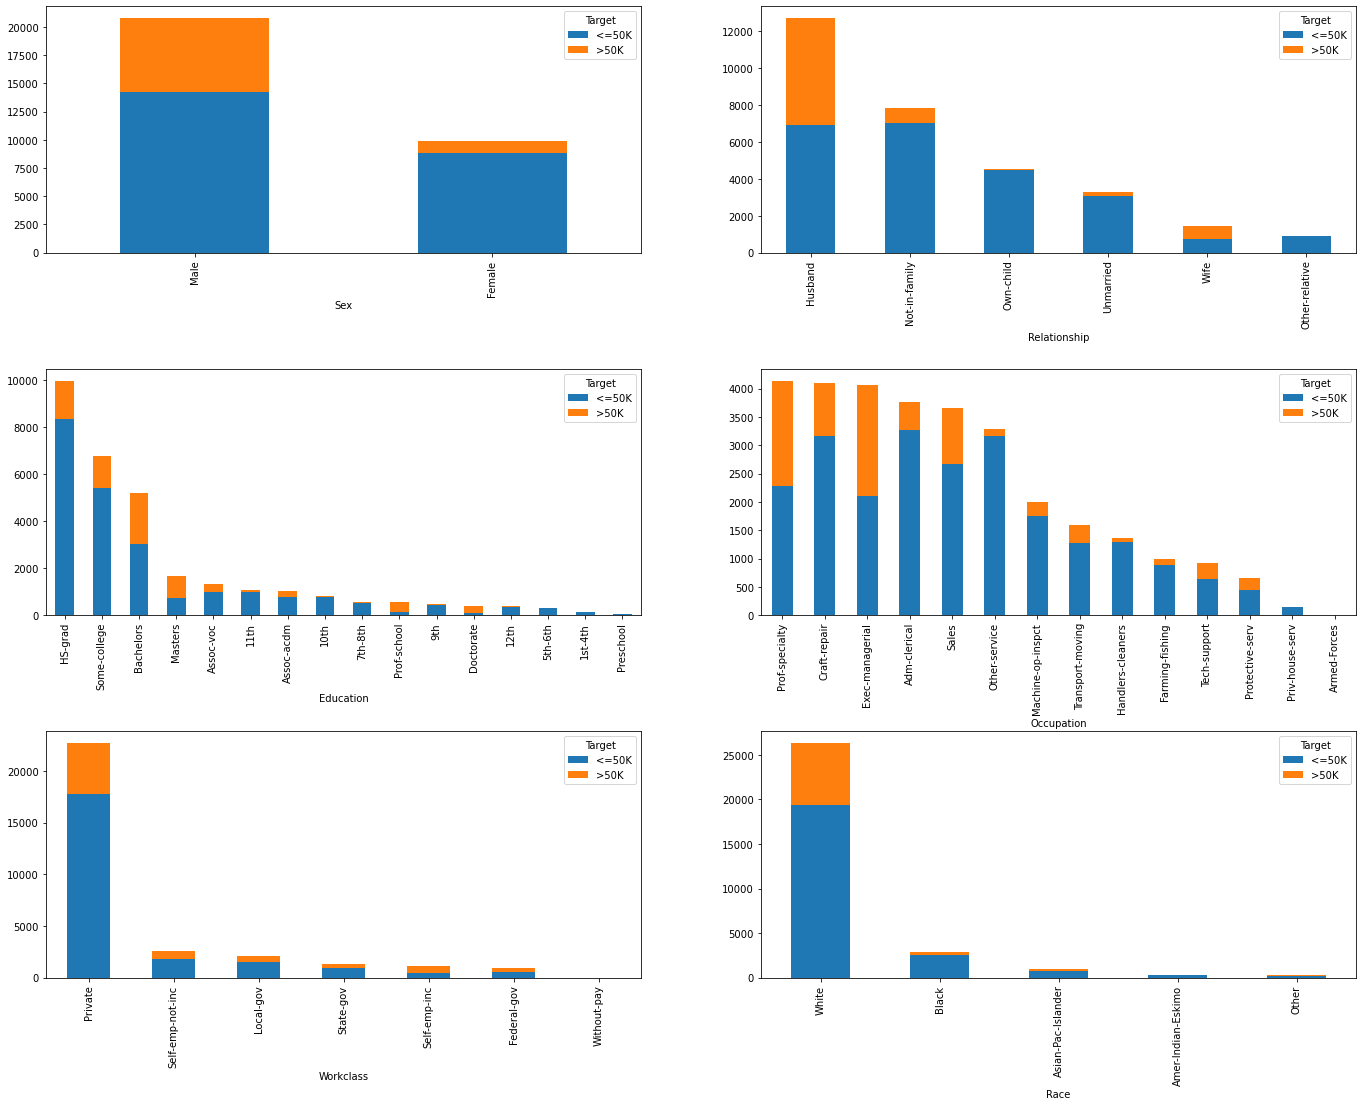

In [28]:
lista = ["Sex", "Relationship", "Education", "Occupation", "Workclass", "Race"]

fig, axes = plt.subplots(nrows = 3, ncols = 2)
plt.tight_layout(pad = .4, w_pad = .5, h_pad = 1.)

m, n = 0, 0
for i in lista:
    g = adult.groupby([i, "Target"]).size().unstack()
    g["sum"] = adult.groupby(i).size()
    g = g.sort_values("sum", ascending = False)[["<=50K", ">50K"]]
    g.plot(kind = "bar", stacked = True, ax = axes[m, n], figsize = (20, 15))
    n += 1
    if n > 1:
        n = 0
        m += 1


Além disso, podemos gerar catplots, das variáveis categóricas pela probabilidade de ganhar mais de 50k por ano. Note que as "barras acinzentadas" em meio às outras representam a variação de renda dentro de cada grupo:

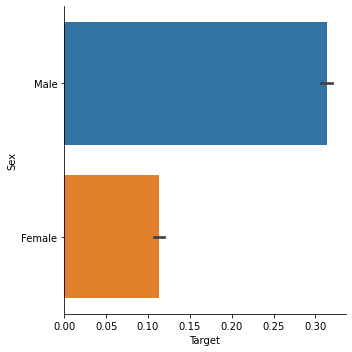

In [29]:
sns.catplot(y = "Sex", x = "Target", kind = "bar", data = analysis);

Aqui vemos uma diferença discrepante: enquanto mais de 30% dos homens ganham mais de 50k por ano, pouco mais de 10% das mulheres também conseguem isso.

Uma desigualdade semelhante está presente em relação às etnias. Observe:

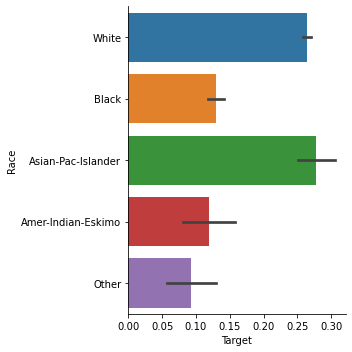

In [30]:
sns.catplot(y = "Race", x = "Target", kind = "bar", data = analysis);

Vamos gerar catplots para o restante das variáveis:

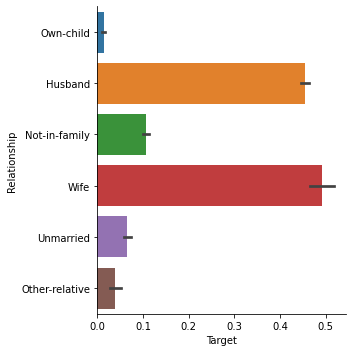

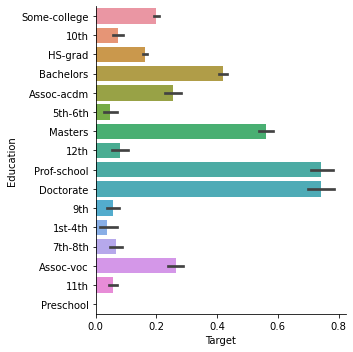

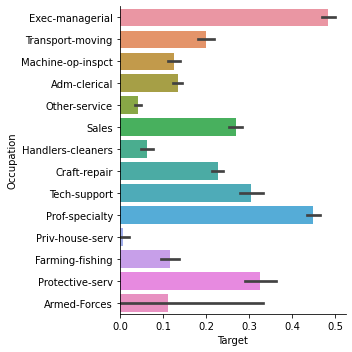

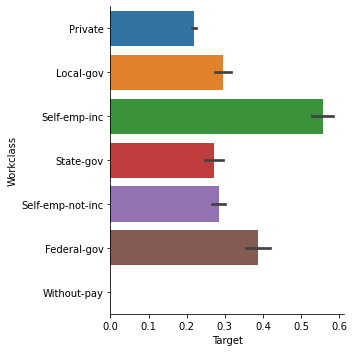

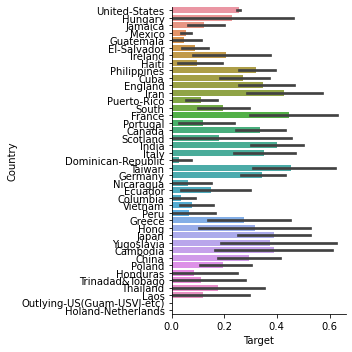

In [31]:
lista = ["Relationship", "Education", "Occupation", "Workclass", "Country"]

for i in lista:
    sns.catplot(y = i, x = "Target", kind = "bar", data = analysis);

Com isso, percebemos que todas as variáveis têm alguma relação com a renda.

No entanto, observando o último catplot, percebe-se uma variação de renda muito grande nos países, exceto nos EUA.

Para compreender melhor essa condição, vamos analisar a distribuição dos dados em relação ao país de origem:

In [32]:
analysis["Country"].value_counts()

United-States                 28059
Mexico                          610
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
China                            68
Italy                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        63
Japan                            59
Poland                           56
Columbia                         56
Iran                             42
Taiwan                           42
Haiti                            42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
Ecuador                     

Aqui, é possível notar que os dados em relação ao país de origem são extremamente desbalanceados. Aproximadamente 91% do total pertence aos EUA. Por isso, essa variável será removida de nossa análise.

## 2.5. Limpeza dos dados:

Primeiramente, vamos remover as colunas não interessantes do dataset. 

Em nossa análise, foi definido que as colunas "fnlwgt" e "Country" não são pertinentes. No entanto, também podemos remover "Education", uma vez que "Education-Num" apresenta basicamente as mesmas informações, mas já em uma forma numérica.

In [33]:
adult = adult.drop(["Country", "fnlwgt", "Education"], axis = 1)
testAdult = testAdult.drop(["Country", "fnlwgt", "Education"], axis = 1)

Agora, vamos remover as linhas duplicadas:

In [34]:
adult.drop_duplicates(keep = "first", inplace = True)

Podemos transformar os dados não-numéricos em numéricos da seguinte forma:

In [35]:
cat_to_num = ["Workclass", "Occupation", "Race", "Sex", "Relationship", "Martial Status"]

adult[cat_to_num] = adult[cat_to_num].apply(prep.LabelEncoder().fit_transform)

testAdult[cat_to_num] = testAdult[cat_to_num].apply(prep.LabelEncoder().fit_transform)

adult.head()

,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Target
0,34,2,10,0,3,3,4,1,0,0,44,<=50K
1,58,1,6,2,13,0,4,1,0,0,40,<=50K
2,25,2,10,4,6,1,4,1,0,0,42,<=50K
3,24,2,10,0,0,1,4,0,0,0,40,<=50K
4,57,3,9,2,13,0,4,1,5178,0,60,>50K


Também vamos transformar a variável de classe em binária com zeros e uns, para melhor aplicar nossos modelos:

In [36]:
adult_reg = adult.copy()
adult_reg["Target"] = prep.LabelEncoder().fit_transform(adult_reg["Target"])

Finalmente, vamos dividir nosso dataset em X e Y, onde Y é a variável de classe e X são as restantes:

In [37]:
Y_train = adult_reg.pop("Target")
X_train = adult_reg

# 3. Aplicação de Modelos:

## 3.1. Rede Neural com Tensorflow:

Vamos criar um modelo de rede neural, utilizando duas camadas ocultas, com um algoritmo de Random Search, de modo a otimizar os hiperparâmetros pertinentes. Estes são dois valores de regularização (l1, l2), e o número de neurônios em cada camada.

Para regularização, utilizaremos uma estratégia do Tensorflow chamada "Early Stopping", ou seja, se a métrica de acurácia não melhorar dentro de um determinado número de iterações, o programa interrompe o treinamento, mesmo que o número total de epochs não tenha sido atingindo. Além disso, vamos restringir os pesos da rede, fazendo uso de duas penalizações (l1 e l2), que devemos encontrar o valor ideal. Finalmente, temos que encontrar o tamanho ideal das duas camadas ocultas. No total, portanto, temos quatro números a serem otimizados.

Faremos uso de uma metodologia de Random Search. A partir de uma variedade de valores, será escolhida aleatoriamente uma combinação de quatro valores: um para o número de perceptrons de cada camada escondida (n1 e n2); e um para cada penalização (l1 e l2). No total, serão escolhidas 200 dessas combinações.

In [38]:
n_iter = 100

n_neurons = []
pen = []

for i in range(n_iter): #Gerando as 200 combinações:
    n1 = random.randrange(25, 101, 5) #Vamos pegar apenas uma amostragem dos valores entre 25 e 100.
    n2 = random.randrange(20, n1, 5)
    n_neurons.append((n1, n2))
    
    l1 = random.choice([0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1])
    l2 = random.choice([0, 1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1e-1])
    pen.append((l1, l2))

Agora, vamos criar um DataFrame com as combinações obtidas:

In [39]:
params = {"n_neurons": n_neurons, "penalizações": pen, "iterações": n_iter*[None], "auc": n_iter*[None]}
params = pd.DataFrame(params)
params = params[["n_neurons", "penalizações", "iterações", "auc"]]
params.head()

,n_neurons,penalizações,iterações,auc
0,"(75, 20)","(0, 0.1)",None,None
1,"(70, 25)","(0, 0.001)",None,None
2,"(50, 25)","(1e-10, 0.01)",None,None
3,"(90, 45)","(0.001, 1e-10)",None,None
4,"(35, 30)","(1e-05, 0.1)",None,None


Note que os outputs na camada "n_neurons" são tuplas que representam o número de neurônios na primeira e na segunda camada escondida, respectivamente; as saídas em "penalizações" são tuplas com os valores das duas regularizações apresentadas. "iterações" e "auc" serão completadas em seguida. A primeira irá armazenar o número de iterações completas até a parada, devido ao Early Stopping. Já a segunda deve armazenar o score de AUC no Early Stopping.

Para completar a tabela, vamos definir uma função que cria modelos para treinamento.

Para treinar os modelos, vamos definir o tamanho dos "lotes", além da fração dos dados que serão separados para validação e o número máximo de iterações (epochs). Para separar os dados de validação, usamos a seguinte função:

In [40]:
X_train1, X_val, Y_train1, Y_val = train_test_split(X_train, Y_train, test_size=0.20)

In [41]:
def create_model(n_neurons = (10,10), pen = (.001, .001)):
    
    n_features = X_train1.shape[1] #Número de atributos que serão utilizados
    
    ops.reset_default_graph() #Resetando as redes neurais treinadas até aqui (importante para testes)
    
    model = Sequential()
    model.add(Dense(n_neurons[0], input_shape = (n_features,), activation = "relu", 
                    kernel_regularizer = regularizers.l1_l2(l1 = pen[0], l2 = pen[1]), 
                    bias_regularizer = regularizers.l1_l2(l1 = pen[0], l2 = pen[1])))
    model.add(Dense(n_neurons[1], activation = "relu", 
                    kernel_regularizer = regularizers.l1_l2(l1 = pen[0], l2 = pen[1]), 
                    bias_regularizer = regularizers.l1_l2(l1 = pen[0], l2 = pen[1])))
    model.add(Dense(1, activation = "sigmoid", 
                    kernel_regularizer = regularizers.l1_l2(l1 = pen[0], l2 = pen[1]), 
                    bias_regularizer = regularizers.l1_l2(l1 = pen[0], l2 = pen[1])))
    
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = [keras.metrics.AUC()])
    return model

Aqui temos dois parâmetros, "kernel_regularizer" e "bias_regularizer", que são os valores de penalização que definimos. Além disso, os modelos precisam de duas funções para serem compilados: uma função loss e um otimizador. Como loss, vamos utilizar "binary_crossentropy", já que é um modelo de classificação binário, e a saída do modelo é uma probabilidade. Como métrica, será utilizada a AUC.

Primeiramente, vamos definir o Early Stopping que será utilizado: se a AUC em relação ao conjunto de validação não melhorar em dez iterações, o programa para:

In [42]:
es = EarlyStopping(monitor = "val_auc", patience = 10)

Agora vamos criar um modelo para cada combinação adquirida com o Random Search, finalizando o preenchimento da tabela:

In [43]:
%%time
for i in tqdm(range(n_iter)):
    model = create_model(params.loc[i, "n_neurons"], params.loc[i, "penalizações"])
    
    history = model.fit(X_train1, Y_train1, epochs = 50, validation_data = (X_val, Y_val), 
                        batch_size = 96, shuffle = True, verbose = False, callbacks = [es]) 
    
    params.loc[i, "iterações"] = len(history.history["val_auc"])
    params.loc[i, "auc"] = history.history["val_auc"][-1]

100%|██████████| 100/100 [12:12<00:00,  7.32s/it]

CPU times: user 22min 33s, sys: 2min 55s, total: 25min 29s
Wall time: 12min 12s


Vamos reordenar o dataframe, de modo que os dez melhores modelos apareçam em ordem crescente de acurácia:

In [44]:
params = params.iloc[np.argsort(params.loc[:,'auc']),:]

Visualizando os dez melhores resultados:

In [45]:
params.tail(10)

,n_neurons,penalizações,iterações,auc
48,"(50, 35)","(0, 0.001)",31,0.860781
25,"(100, 60)","(1e-10, 1e-10)",16,0.862435
85,"(40, 35)","(1e-15, 1e-05)",16,0.863931
40,"(90, 70)","(1e-05, 1e-05)",11,0.864176
46,"(100, 20)","(0, 0.001)",31,0.865637
89,"(25, 20)","(1e-10, 0)",20,0.868536
27,"(30, 25)","(0, 1e-05)",22,0.869732
47,"(90, 25)","(1e-05, 1e-05)",16,0.86992
66,"(90, 80)","(1e-15, 1e-05)",15,0.870221
33,"(95, 70)","(1e-10, 1e-10)",16,0.870256


Com a melhor rede encontrada, definimos e treinamos nosso modelo final:

In [46]:
n_neurons = params.iloc[-1,0]
pen = params.iloc[-1,1]
epochs = params.iloc[-1,2]

NN_TF = create_model(n_neurons, pen)

history = NN_TF.fit(X_train1, Y_train1, epochs = epochs, validation_data = (X_val, Y_val),
                        batch_size = 96, shuffle = True, verbose = 1)

Epoch 1/16
227/227 [==============================] - 1s 3ms/step - loss: 9.2541 - auc: 0.6499 - val_loss: 0.6181 - val_auc: 0.7954
Epoch 2/16
227/227 [==============================] - 0s 2ms/step - loss: 0.6786 - auc: 0.7648 - val_loss: 0.5128 - val_auc: 0.8135
Epoch 3/16
227/227 [==============================] - 0s 2ms/step - loss: 1.8392 - auc: 0.7559 - val_loss: 1.1525 - val_auc: 0.6536
Epoch 4/16
227/227 [==============================] - 0s 2ms/step - loss: 1.0790 - auc: 0.7598 - val_loss: 0.6008 - val_auc: 0.8184
Epoch 5/16
227/227 [==============================] - 0s 2ms/step - loss: 0.7846 - auc: 0.7858 - val_loss: 0.9998 - val_auc: 0.8293
Epoch 6/16
227/227 [==============================] - 0s 2ms/step - loss: 1.7256 - auc: 0.7871 - val_loss: 2.2065 - val_auc: 0.7626
Epoch 7/16
227/227 [==============================] - 0s 2ms/step - loss: 1.1577 - auc: 0.8132 - val_loss: 0.5887 - val_auc: 0.8516
Epoch 8/16
227/227 [==============================] - 0s 2ms/step - loss: 0.

## 3.2. Regressão Logística:

Vamos novamente utilizar o Random Search para escolher os melhores hiperparâmetros, e a AUC como métrica:

In [47]:
%%time
logreg = LogisticRegression(solver = "liblinear", random_state = 36)
hyperparams = dict(C = np.linspace(0, 10, 100), 
                     penalty = ["l2", "l1"])

clf = RandomizedSearchCV(logreg, hyperparams, scoring = "roc_auc", n_iter = 50, 
                         cv = 2, n_jobs = -1, random_state = 0, verbose = 2)

search_logreg = clf.fit(X_train1, Y_train1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


CPU times: user 963 ms, sys: 139 ms, total: 1.1 s
Wall time: 9.04 s


In [48]:
print("Hiperparâmetros:", search_logreg.best_params_)
print("Melhor score:", search_logreg.best_score_ )

Hiperparâmetros: {'penalty': 'l2', 'C': 7.373737373737374}
Melhor score: 0.8484481414476974


Treinando o modelo final:

In [49]:
logreg = LogisticRegression(C = search_logreg.best_params_["C"], 
                            penalty = search_logreg.best_params_["penalty"],
                            solver = "liblinear", random_state = 36)

logreg.fit(X_train1, Y_train1)

LogisticRegression(C=7.373737373737374, random_state=36, solver='liblinear')

## 3.3. Random Forest:

Aqui, tem-se dois hiperparâmetros relevantes: o "depth" das árvores e o número de estimadores.

Vamos usar uma metodologia de Random Search para otimizá-los:

In [50]:
%%time
rf = sklearn.ensemble.RandomForestClassifier()

hyperparams = {"n_estimators":[i for i in range(0, 710, 10)], 
                     "max_depth":[i for i in range(0, 30)]}

clf = RandomizedSearchCV(rf, hyperparams, scoring = "roc_auc", n_iter = 50, 
                         cv = 2, n_jobs = -1, random_state = 0, verbose = 2)

search_rf = clf.fit(X_train1, Y_train1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


CPU times: user 12.1 s, sys: 130 ms, total: 12.2 s
Wall time: 2min 22s


In [51]:
print("Hiperparâmetros:", search_rf.best_params_)
print("Melhor score:", search_rf.best_score_ )

Hiperparâmetros: {'n_estimators': 660, 'max_depth': 11}
Melhor score: 0.9134952867164976


Treinando o modelo final:

In [52]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators = search_rf.best_params_["n_estimators"], 
                                             max_depth = search_rf.best_params_["max_depth"])
rf.fit(X_train1, Y_train1)

RandomForestClassifier(max_depth=11, n_estimators=660)

## 3.4. XGBoost:

Utilizando Random Search, vamos otimizar os hiperparâmetros "depth" e "estimators":

In [53]:
%%time
xgb = XGBClassifier()

hyperparams = {"n_estimators":[i for i in range(0, 260, 10)], 
                     "max_depth":[i for i in range(0, 30)]}

clf = RandomizedSearchCV(xgb, hyperparams, scoring = "roc_auc", n_iter = 50, 
                         cv = 2, n_jobs = -1, random_state = 0, verbose = 2)

search_xgb = clf.fit(X_train1, Y_train1)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


CPU times: user 4.66 s, sys: 0 ns, total: 4.66 s
Wall time: 1min 52s


In [54]:
print("Hiperparâmetros:", search_xgb.best_params_)
print("Melhor score:", search_xgb.best_score_ )

Hiperparâmetros: {'n_estimators': 230, 'max_depth': 2}
Melhor score: 0.9234301146214394


Mantendo o modelo final:

In [55]:
xgb = search_xgb.best_estimator_

## 3.5. Árvore de Decisão:

Aqui, o principal hiperparâmetro é "depth". Utilizando GridSearchCV:

In [56]:
dt = sklearn.tree.DecisionTreeClassifier()

In [57]:
grid_params_dt = {"max_depth":[i for i in range(1,31)]}  

grid_dt = GridSearchCV(dt, grid_params_dt, cv = 2, verbose = 1, n_jobs = -1, scoring = "roc_auc") 

In [58]:
%%time
grid_dt.fit(X_train1, Y_train1) 

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 244 ms, sys: 14.5 ms, total: 259 ms
Wall time: 1.08 s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='roc_auc', verbose=1)

In [59]:
print("Hiperparâmetros:", grid_dt.best_estimator_)
print("Melhor score:", grid_dt.best_score_)

Hiperparâmetros: DecisionTreeClassifier(max_depth=7)
Melhor score: 0.8891426589537335


Mantendo o melhor modelo encontrado:

In [60]:
dt = grid_dt.best_estimator_

# 4. Validação e Score dos métodos definidos:

Agora, vamos gerar predições, utilizando o conjunto de validação, a partir dos modelos definidos até aqui: a rede neural,  a regressão logística, a floresta aleatória, o SVM, o XGBoost e a árvore de decisão. Vamos compará-las com a classificação correta. Assim, descobrimos aquele com maior AUC:

In [61]:
print("AUC --- Rede Neural: {:.4f}".format(roc_auc_score(Y_val, NN_TF.predict(X_val).squeeze())))
print('AUC --- Log. Reg.: {:.4f}'.format(roc_auc_score(Y_val, logreg.predict_proba(X_val)[:,1])))
print("AUC --- Random Forest: {:.4f}".format(roc_auc_score(Y_val, rf.predict_proba(X_val)[:,1])))
print("AUC --- XGBoost: {:.4f}".format(roc_auc_score(Y_val, xgb.predict_proba(X_val)[:,1])))
print("AUC --- Árvore de Decisão: {:.4f}".format(roc_auc_score(Y_val, dt.predict_proba(X_val)[:,1])))

AUC --- Rede Neural: 0.8598
AUC --- Log. Reg.: 0.8433
AUC --- Random Forest: 0.9154
AUC --- XGBoost: 0.9258
AUC --- Árvore de Decisão: 0.8942


Finalmente, selecionamos o com maior acurácia, revertemos a transformação binária da variável "Target" e geramos as predições:

In [62]:
YtestPred = xgb.predict(testAdult)
YtestPred = le.inverse_transform(YtestPred)
submission = pd.DataFrame(YtestPred, columns = ["income"])
submission.to_csv("submission.csv", index = True, index_label = "Id")